In [1]:
import numpy as np
import random as rng
import numpy.random as numRand
import optproblems
from optproblems import cec2005
from optproblems import *
import typing 
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

In [2]:
# mutation functions

# not actually used so I don't haev to comment it ;D
def bitFlip(genotype, flip_probability):
    p = flip_probability
    
    for i in range(len(genotype)):
        if p >= np.random.rand(1, 1):
            genotype[i] = not(genotype[i])
    return genotype
#end

# gaussian convolution
# Add gaussian-distributed random numbers to a random selection of values from the genotype
# variance: variance of the distribution random numbers will be generated from
# min: minimum number genotype's values can be 
# max: maximum number genotype's values can be
# noise_probability: probability that gaussian number will be added a value in the genotype
def gaussianConvolution(genotype, variance=1, min = -100, max = 100, noise_probability=0.5):
    p = noise_probability #probability of adding noise to a genotype value
    var = variance        #variance of the gaussian distribution which will be added to a genotype val
    mu = 0                #mean of the normal distribution
    
    for i in range(len(genotype)): #for every genotype member
        # if the noise probability is greater than a random number (between 0 and 1)
        if p >= np.random.rand(1, 1): #a 1x1 array of random numbers (a.k.a a random number)
            #generate a random nnumber from a gaussian distribution
            randy_num = rng.normalvariate(mu, var)
            
            #until (current genotype value + randy_num) is between min and max
            while not (min <= genotype[i] + randy_num <= max):
                randy_num = rng.normalvariate(mu, var)
            #end
            
            genotype[i] = (genotype[i] + randy_num) #update current value from genotype
        #end
    return genotype
#end

mutate_functions = {"bit flip":bitFlip, "g convolve":gaussianConvolution}

In [3]:
# test mutation

pop = np.array([2, 2, 2, 2, 1, 1, 1, 1], dtype="float")
mut_pop = mutate_functions["g convolve"](pop, 1, 0.5)
mut_pop

array([2.        , 2.        , 2.        , 2.        , 1.        ,
       2.21292908, 0.56668742, 0.82212987])

In [4]:
# recombination

# swap values between 2 vectors starting from a random index and ending at another random index
# (index circularly)
# vec_1: a vector
# vec_2: a vector
def twoPtCrossover(vec_1, vec_2):
    #TODO - implement
    vec_3, vec_4 = vec_1, vec_2
    return vec_3, vec_4
#end

#swap values between 2 vectors starting from a random index
#vec_1: a vector
#vec_2: a vector
def onePtCrossover(vec_1, vec_2):
    #TODO handle unequal-length vecs
    #TODO handle empty vecs
    vec_1 = vec_1.copy()
    vec_2 = vec_2.copy()
    
    # choose a random integer (between bidx and pop length) and
    # swap vector values between that index and the vectors' ends
    cross_beg_idx = int(rng.uniform(0, len(vec_1)))
    
    # if crossover start is greater than first index 
    # (crossing from zero would just output the same 2 vectors in reverse order)
    if cross_beg_idx > 0:
        # swap the values
        for idx in range(cross_beg_idx, len(vec_1)):
            swap = vec_1[idx] #store the value to be swapped
            vec_1[idx] = vec_2[idx]
            vec_2[idx] = swap #swap the value to be swapped
        #end
    #end
    return vec_1, vec_2
#end

recombine_fns = {"1-pt-crossover":onePtCrossover}

In [5]:
# test recombination
pop_1 = [4.0, 3.2, 1.0, 0.5, 6.2]
pop_2 = [10.0, 15.0, 12.2, 9.5, 5.0]

pop_3, pop_4 = onePtCrossover(pop_1, pop_2)

print(pop_3)
pop_4

[4.0, 3.2, 1.0, 9.5, 5.0]


[10.0, 15.0, 12.2, 0.5, 6.2]

In [6]:
#selection

# Assess a genotype's fitness score in relation to a given problem function
# In GA, allows GA to find genotypes with greatest fitness and "naturally select" them
# genotype: a potential solution
# problem: the solution will be assessed on the output it receives when applied to this problem
def assessFitness(genotype, problem):
    if genotype == None:
        fitness = np.inf
    else:
        solution = Individual(genotype)
        problem.evaluate(solution)
        fitness = solution.objective_values
    #end
    
    return fitness
#end

# select the best genotype from the population according to a tournament process
# population: to select individuals from
# tournament_size: size of the group considered for selection
# problem: population members' fitness will be assessed according to their score on this problem
def tournamentSelect(population, tournament_size, problem, debug = False):
    t = tournament_size
    
    select_idx = int(rng.uniform(0, len(population)))
    best_idx = select_idx
    best = population[select_idx]
    
    # for every population element between second and "tournament size"...
    for i in range(0, t):
        # choose a "next" at random from pop
        select_idx = int(rng.uniform(0, len(population)))
        next = population[select_idx]
        if debug:
            print("Fighter: {}\t Fitness: {}".format(next, assessFitness(next, problem)))
        #end
        
        # if fitness of Next better than best...
        if assessFitness(next, problem) < assessFitness(best, problem):
            best = next
        #end
    #end
    
    return best
#end

In [41]:
# test assessFitness()

print(assessFitness([-19.9, 50.35], problem = optproblems.Problem(cec2005.F1(2))))
print(assessFitness([18, -72], problem = optproblems.Problem(cec2005.F4(2))))
print(assessFitness([18, -72, 0, 0, 0, 0, 0, 0, 0, 0], problem = optproblems.Problem(cec2005.F4(10))))

-0.07734837999987576
12.57466809321022
19808.052466147583


In [8]:
# test tournamentSelect()

population = [[-15, 13.9], [-13, 12], [-19.9, 50.35], [5, 50], [-15, 0], [-13, 42], [-3, 59], [4, -4], 
              [-13, 13], [15, 15], [-15, 13.9], [-19.9, 50.35], [-15, 13], [-15, 13], [-10, 0], 
              [-15, 13.9], [8, 2], [-19.9, 90.35], [6, 4], [-19.9, 10.35]]

king_of_fighters = tournamentSelect(population, 10, problem = optproblems.Problem(cec2005.F1(2)), debug =True)

print("King: {}".format(king_of_fighters))

Fighter: [-13, 42]	 Fitness: 527.9227016200002
Fighter: [-13, 12]	 Fitness: 2441.91670162
Fighter: [4, -4]	 Fitness: 5382.318101620001
Fighter: [-10, 0]	 Fitness: 3878.38570162
Fighter: [-19.9, 50.35]	 Fitness: -0.07734837999987576
Fighter: [-13, 13]	 Fitness: 2349.11690162
Fighter: [-19.9, 10.35]	 Fitness: 2283.9146516200003
Fighter: [15, 15]	 Fitness: 4426.98370162
Fighter: [-19.9, 90.35]	 Fitness: 915.9306516199995
Fighter: [-15, 13.9]	 Fitness: 2166.0594816200005
King: [-19.9, 50.35]


In [9]:
#copy eerything except a given element from a list
def copyExcept(copy_this, dont_copy_this):
    list_clone = list()
    for i in range(0, len(copy_this)):
        if copy_this[i] != dont_copy_this:
            list_clone.append(copy_this[i])
    #end
    
    return list_clone
#end

In [10]:
dont_copy = [3, 3]
test_pop = [[1, 1], [2, 2], dont_copy]
print(test_pop)

clone = copyExcept(test_pop, dont_copy)
print(clone)

[[1, 1], [2, 2], [3, 3]]
[[1, 1], [2, 2]]


In [46]:
# genetic algorithm
DFLT_PROBLEM_DIMENSIONS = 10
fit_hist = list()

#TODO docs
# generation_limit:
# population_size:
# problem_dimensions:
# problem:
def geneticAlgorithm(generation_limit = 500, population_size = 100, problem_dimensions = DFLT_PROBLEM_DIMENSIONS, problem = optproblems.Problem(cec2005.F1(DFLT_PROBLEM_DIMENSIONS)), problem_min = -100, problem_max = 100):
    # TODO optimise for fitness checks
    # create population
    pop = list()
    for i in range(population_size):
        pop.append(list(numRand.rand(1, problem_dimensions)[0]))
    #end
    
    glob_best = None
    glob_best_fit = np.inf
    generation = 0
    
    # assess fitnesses and assign best until best is the ideal solution
    while generation < generation_limit:
        generation += 1
        best = None
        best_fit = np.inf
        fit_list = list()
        
        # find the most selectablw genotype in the generation
        for idx in range(0, population_size):
            fit_list.append(assessFitness(pop[idx], problem))
            if  fit_list[idx] < best_fit:
                best = pop[idx].copy()
                best_fit = fit_list[idx]
            #end
        #end
        
        if  best_fit < glob_best_fit:
            glob_best = best.copy()
            glob_best_fit = best_fit
        #end
        
        # create next generation (Q in the pseudo code)
        next_gen_pop = list()
        for i in range(int(population_size/2)):
            # select parents
            parent_1 = tournamentSelect(pop.copy(), int(len(pop)/2), problem)
            copy_pop = copyExcept(pop.copy(), parent_1)
            parent_2 = tournamentSelect(copy_pop, int(len(pop)/2), problem)
            
            # birth some babbies using crossover
            child_1, child_2 = onePtCrossover(parent_1, parent_2)
            
            next_gen_pop.append(mutate_functions["g convolve"](child_1, variance = 1, min = problem_min, max = problem_max))
            next_gen_pop.append(mutate_functions["g convolve"](child_2, variance = 1, min = problem_min, max = problem_max))
        #end
        
        fit_hist.append(best_fit)
        int_best = [int(g) for g in best]
        print("Best : {}    Best fit : {}    Gen {}/{}".format(int_best, best_fit, generation, generation_limit))
        
        pop = next_gen_pop.copy()
    #end
    
    return glob_best_fit
#end



In [68]:
fit_hist = list()
gens = 400
pop_size = 100
dims = 10
prob = optproblems.Problem(cec2005.F4(dims))
min = -100
max = 100

fitness = geneticAlgorithm(generation_limit = gens, population_size = pop_size, problem_dimensions = dims, problem = prob, problem_min = min, problem_max = max)

Best : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    Best fit : 70643.7403769875    Gen 1/400
Best : [0, -1, 0, 0, 0, 1, 0, 0, 0, 0]    Best fit : 69129.14821765738    Gen 2/400
Best : [0, -1, -3, 0, 0, 0, 0, 0, 1, 0]    Best fit : 64465.76743353103    Gen 3/400
Best : [1, -3, -3, 0, 0, 0, 0, 0, 2, 0]    Best fit : 63565.390792675666    Gen 4/400
Best : [-1, -2, -3, 0, 0, 0, 0, -1, 3, 0]    Best fit : 59423.06530969765    Gen 5/400
Best : [-3, 0, -3, 0, 0, 0, -3, 0, 0, -2]    Best fit : 58658.259998297406    Gen 6/400
Best : [-4, -1, -6, 0, 0, 0, -2, 0, 4, 0]    Best fit : 56033.393641257695    Gen 7/400
Best : [1, -4, -6, 0, -1, -1, -2, -1, 0, 0]    Best fit : 52872.18456906896    Gen 8/400
Best : [-4, -1, -5, -3, -1, 1, 0, 0, 0, 0]    Best fit : 51745.22715317692    Gen 9/400
Best : [-4, -4, -7, 0, 0, -1, -2, -1, 0, 0]    Best fit : 48976.87185679061    Gen 10/400
Best : [-5, -4, -7, 0, -2, 2, 0, -2, -3, 0]    Best fit : 47197.16982034505    Gen 11/400
Best : [-4, -3, -8, 0, -6, -2, -5, -6, 1, -

Best : [-9, -33, -22, -21, 13, 7, -20, -7, 15, -10]    Best fit : 10377.972900852943    Gen 88/400
Best : [-7, -28, -22, -21, 13, 6, -20, -8, 14, 0]    Best fit : 10648.881036009394    Gen 89/400
Best : [-8, -33, -23, -21, 14, 2, -20, -9, 15, -7]    Best fit : 10173.488883971086    Gen 90/400
Best : [-7, -36, -20, -22, 16, 2, -15, -9, 13, -7]    Best fit : 10203.946191915891    Gen 91/400
Best : [-11, -35, -18, -22, 17, 3, -21, -11, 24, -10]    Best fit : 9567.05421318719    Gen 92/400
Best : [-3, -37, -17, -25, 12, 2, -13, -12, 21, -13]    Best fit : 9906.286302879897    Gen 93/400
Best : [0, -37, -24, -19, 16, 5, -18, -13, 19, -17]    Best fit : 9408.903759006878    Gen 94/400
Best : [-7, -30, -23, -23, 12, 6, -20, -13, 23, -15]    Best fit : 9509.51590133059    Gen 95/400
Best : [0, -31, -20, -30, 15, -1, -23, -7, 23, -10]    Best fit : 9527.042612262205    Gen 96/400
Best : [-1, -32, -21, -27, 16, 3, -17, -13, 17, -9]    Best fit : 9447.262497140497    Gen 97/400
Best : [-4, -35, -

Best : [12, -50, -27, -47, 40, 26, -41, -20, 41, -30]    Best fit : 3291.6051234249867    Gen 173/400
Best : [14, -57, -26, -43, 41, 26, -41, -20, 42, -29]    Best fit : 3259.8287125024603    Gen 174/400
Best : [14, -57, -26, -43, 41, 26, -43, -19, 44, -28]    Best fit : 2933.30729578207    Gen 175/400
Best : [15, -57, -25, -43, 41, 25, -45, -19, 42, -20]    Best fit : 3049.0524475507113    Gen 176/400
Best : [15, -56, -28, -45, 40, 31, -42, -23, 43, -32]    Best fit : 3012.4046491225313    Gen 177/400
Best : [15, -54, -23, -44, 41, 29, -45, -24, 47, -20]    Best fit : 2963.94131061406    Gen 178/400
Best : [12, -53, -26, -44, 42, 31, -50, -22, 42, -28]    Best fit : 2831.6838540293356    Gen 179/400
Best : [13, -53, -26, -44, 44, 31, -51, -22, 42, -29]    Best fit : 2502.4345210927618    Gen 180/400
Best : [13, -53, -27, -44, 44, 29, -53, -22, 42, -29]    Best fit : 2630.56975949256    Gen 181/400
Best : [12, -53, -27, -43, 47, 31, -54, -22, 44, -26]    Best fit : 2354.140563060254   

Best : [31, -75, -13, -77, 75, 46, -88, -25, 73, -35]    Best fit : -369.350456476164    Gen 255/400
Best : [32, -76, -16, -76, 75, 47, -84, -28, 71, -34]    Best fit : -361.7316684403703    Gen 256/400
Best : [32, -76, -16, -77, 75, 47, -84, -28, 74, -37]    Best fit : -379.7190943100745    Gen 257/400
Best : [32, -76, -15, -77, 78, 46, -89, -27, 74, -37]    Best fit : -386.8778009165205    Gen 258/400
Best : [33, -78, -15, -77, 78, 47, -88, -27, 72, -35]    Best fit : -397.76194004289266    Gen 259/400
Best : [32, -79, -12, -78, 78, 48, -89, -27, 75, -37]    Best fit : -419.02974048001334    Gen 260/400
Best : [33, -79, -13, -78, 79, 47, -88, -27, 74, -38]    Best fit : -416.26605478337405    Gen 261/400
Best : [35, -80, -15, -77, 78, 48, -89, -27, 75, -38]    Best fit : -424.41619845308827    Gen 262/400
Best : [35, -79, -13, -81, 79, 48, -89, -25, 74, -39]    Best fit : -427.75221956097556    Gen 263/400
Best : [33, -79, -13, -80, 79, 47, -89, -25, 74, -38]    Best fit : -431.36862

Best : [35, -82, -11, -83, 83, 47, -89, -26, 75, -38]    Best fit : -447.6372923888499    Gen 337/400
Best : [35, -83, -10, -83, 83, 47, -89, -27, 75, -38]    Best fit : -449.16519418839425    Gen 338/400
Best : [35, -83, -10, -83, 83, 47, -89, -27, 75, -38]    Best fit : -449.46980274871925    Gen 339/400
Best : [35, -83, -10, -83, 83, 47, -89, -27, 76, -39]    Best fit : -449.38805660120073    Gen 340/400
Best : [35, -83, -10, -83, 83, 46, -89, -27, 76, -39]    Best fit : -449.0901440303169    Gen 341/400
Best : [35, -83, -10, -83, 83, 47, -89, -27, 76, -38]    Best fit : -448.9566217947088    Gen 342/400
Best : [35, -83, -10, -83, 83, 46, -89, -27, 76, -37]    Best fit : -448.0181327783088    Gen 343/400
Best : [35, -82, -10, -83, 82, 47, -89, -27, 76, -38]    Best fit : -447.6870723350329    Gen 344/400
Best : [35, -82, -10, -83, 83, 47, -89, -28, 76, -37]    Best fit : -448.0665515399623    Gen 345/400
Best : [35, -82, -10, -84, 83, 47, -88, -28, 76, -39]    Best fit : -447.173285

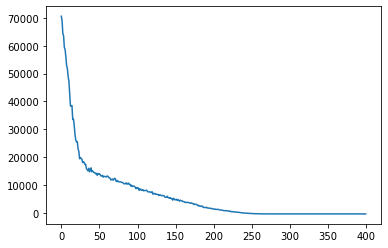

In [69]:
plt.plot(range(0, gens), fit_hist[0:gens])